In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.fftpack import fft

path_to_inflow = "../observations/wwtp.csv"
path_to_dmi_data = "../observations/dmi.csv"

inflow = pd.read_csv(path_to_inflow, parse_dates=True, index_col=0, sep=";")
inflow.index.name = "time"
inflow.index = inflow.index.tz_localize("Europe/Copenhagen", ambiguous="NaT").tz_convert("utc")

climate = pd.read_csv(path_to_dmi_data, parse_dates=True, index_col=0, sep=",")

horsens = inflow.merge(climate, left_index=True, right_index=True, how="inner")
scaler = StandardScaler()

features_to_keep =  ['acc_precip', 'mean_pressure', 'mean_relative_hum', 'mean_temp', 'temp_soil_30', 'FB20F11_81']
horsens = horsens[features_to_keep]
horsens = horsens.fillna(method="ffill")

/tmp/ipykernel_448195/1428089478.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  horsens = horsens.fillna(method="ffill")


In [2]:
def add_fourier_terms(df, period=24):
    timestamps = (df.index - df.index[0]).total_seconds() / 3600  # Convert index to hours
    omega = 2 * np.pi / period
    df['fourier_sin'] = np.sin(omega * timestamps)
    df['fourier_cos'] = np.cos(omega * timestamps)
    return df

horsens = add_fourier_terms(horsens, period=24)

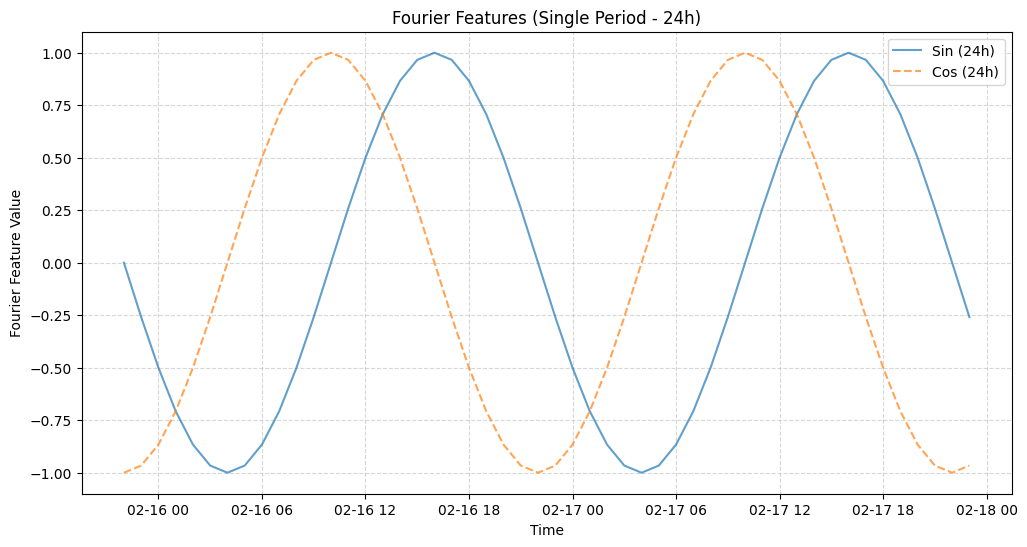

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(horsens.index[-50:], horsens['fourier_sin'][-50:], label='Sin (24h)', linestyle='-', alpha=0.7)
plt.plot(horsens.index[-50:], horsens['fourier_cos'][-50:], label='Cos (24h)', linestyle='--', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Fourier Feature Value")
plt.title("Fourier Features (Single Period - 24h)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()



In [4]:

y = horsens["FB20F11_81"]
X = horsens.drop(columns=["FB20F11_81"])
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

forecast_horizon = 24
gap_size = forecast_horizon + 1  

gap_index = int(len(horsens) * 0.8)
train_horsens = horsens.iloc[:gap_index - gap_size]
test_horsens = horsens.iloc[gap_index:]

train_horsens = train_horsens.dropna()
test_horsens = test_horsens.dropna()

X_train = train_horsens.drop(columns=['FB20F11_81'])
y_train = train_horsens['FB20F11_81']
X_test = test_horsens.drop(columns=['FB20F11_81'])
y_test = test_horsens['FB20F11_81']

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


In [5]:
single_step_model = xgb.XGBRegressor(objective='reg:squarederror')
single_step_model.fit(X_train_scaled, y_train)  


def recursive_forecast(model, X_test_scaled, forecast_horizon):
    X_temp = X_test_scaled.copy()
    y_pred_recursive = np.zeros((X_test_scaled.shape[0], forecast_horizon))
    
    for step in range(forecast_horizon):
        y_next_pred = model.predict(X_temp) 
        y_pred_recursive[:, step] = y_next_pred  
        
        X_temp = X_temp.copy()
        if 'FB20F11_81' in X_temp.columns:
            X_temp['FB20F11_81'] = y_next_pred
        
        for col in X_temp.columns:
            if '_sin_' in col or '_cos_' in col:
                continue 
            X_temp[col] = np.roll(X_temp[col], -1)
    
    return y_pred_recursive


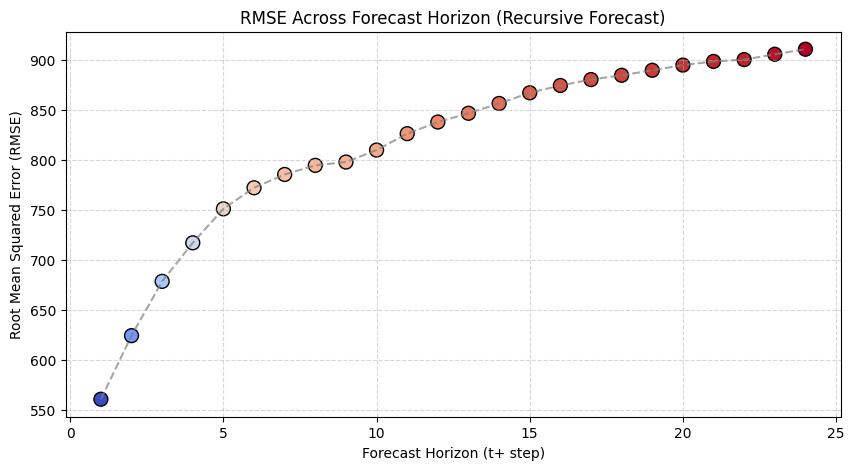

In [6]:
y_pred_recursive = recursive_forecast(single_step_model, X_test_scaled, forecast_horizon)

rmse_recursive = np.sqrt([mean_squared_error(y_test, y_pred_recursive[:, step])
                          for step in range(forecast_horizon)])

steps = np.arange(1, forecast_horizon + 1)
plt.figure(figsize=(10, 5))
scatter = plt.scatter(steps, rmse_recursive, c=rmse_recursive, cmap='coolwarm', edgecolors='black', s=100)
plt.plot(steps, rmse_recursive, linestyle='--', color='gray', alpha=0.7)
plt.xlabel("Forecast Horizon (t+ step)")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE Across Forecast Horizon (Recursive Forecast)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


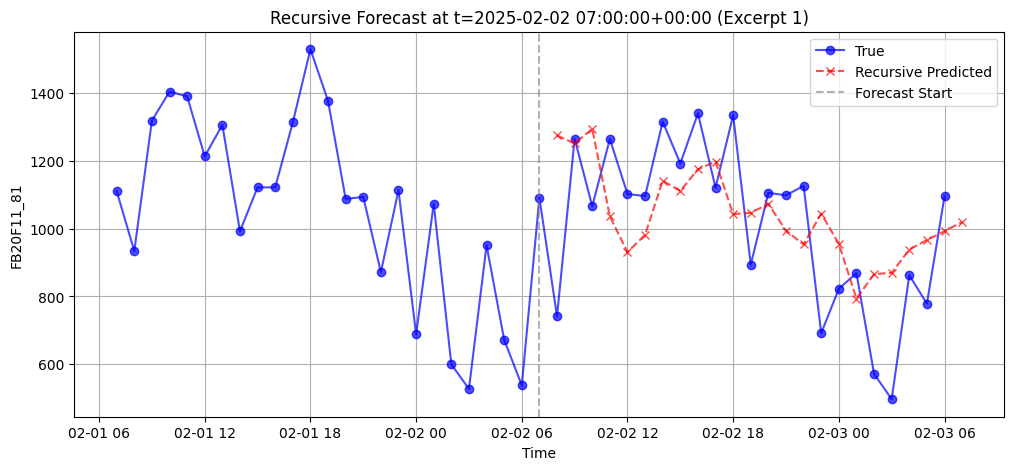

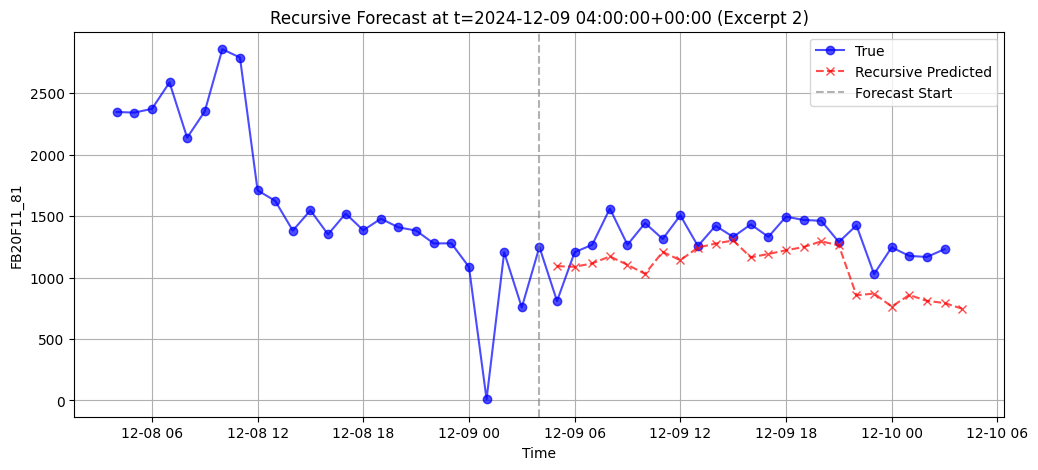

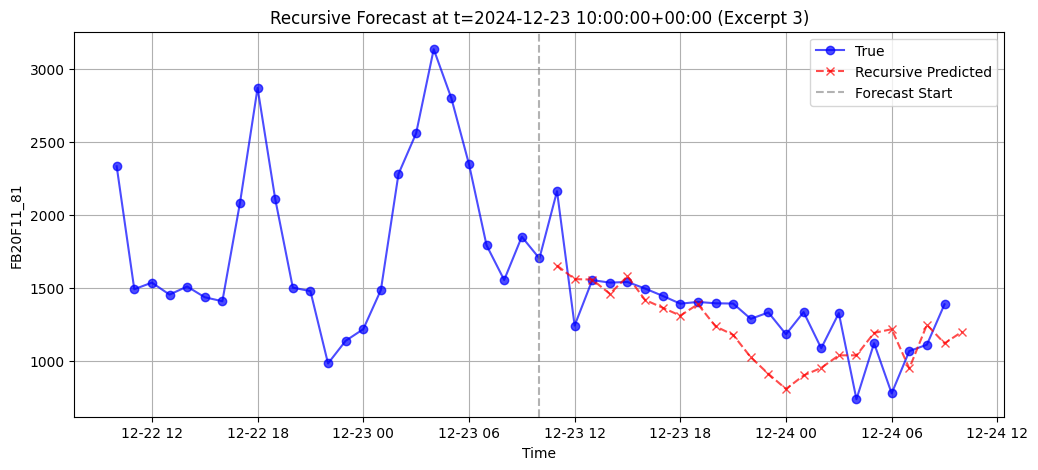

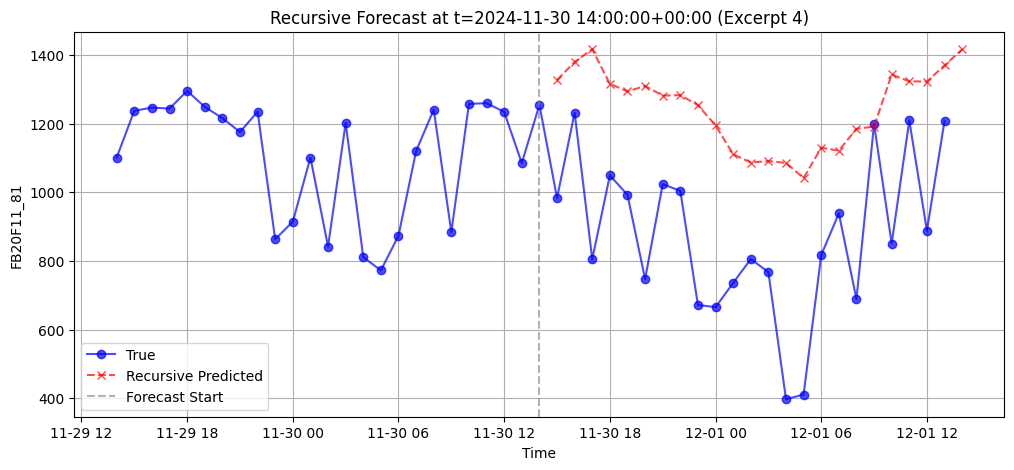

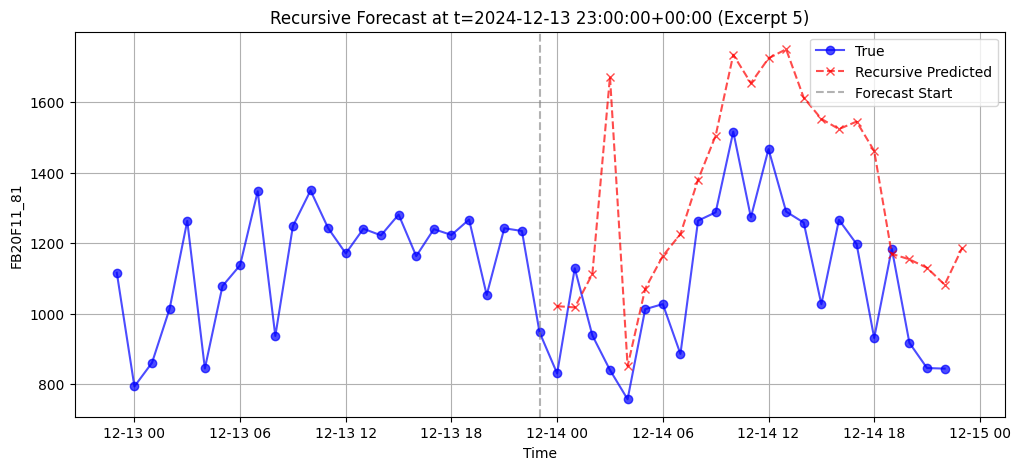

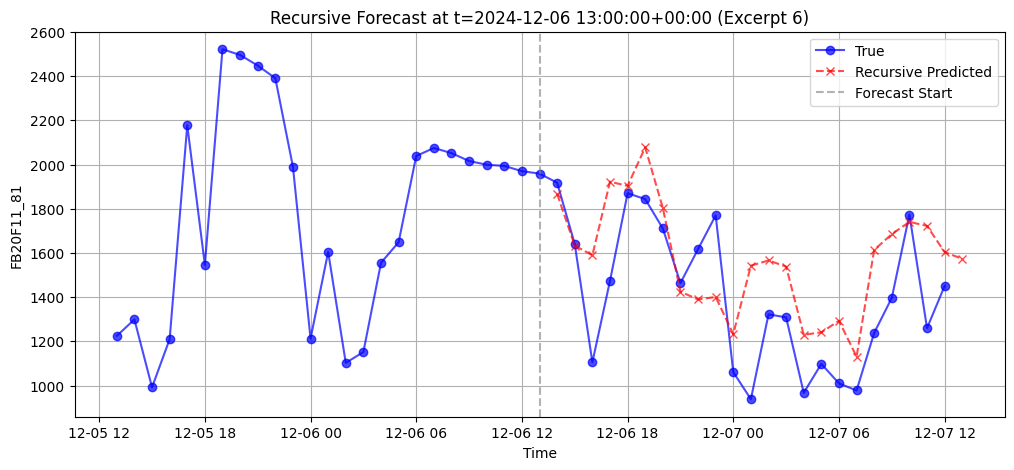

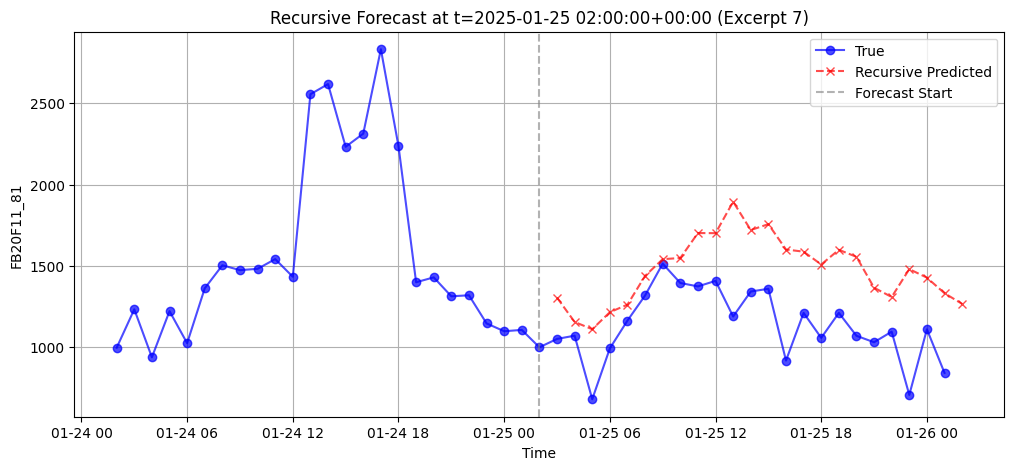

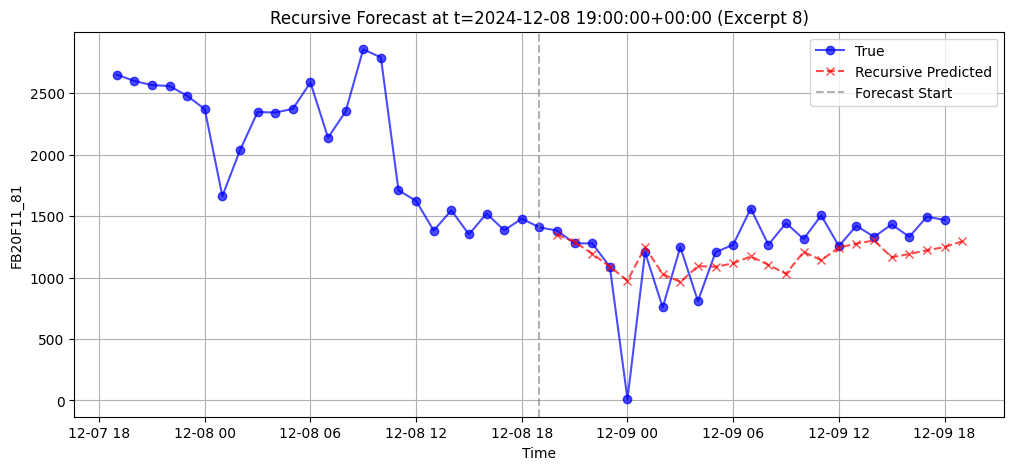

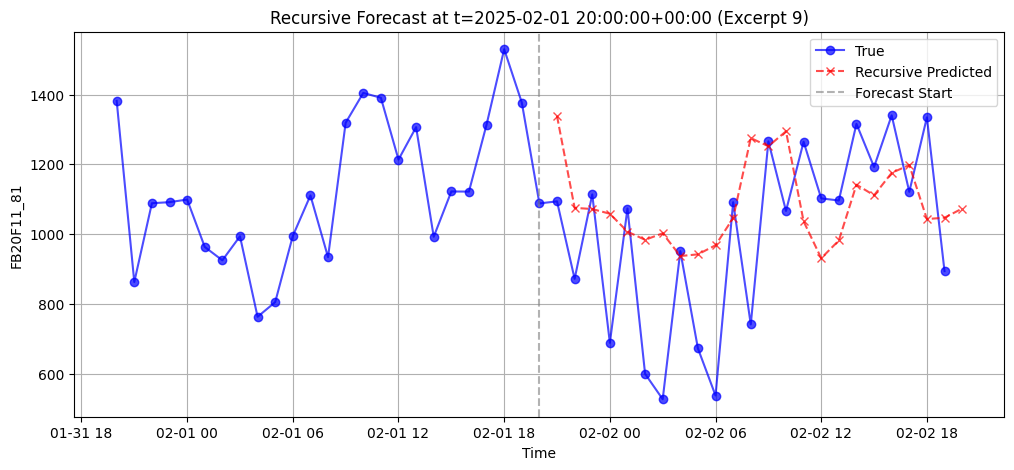

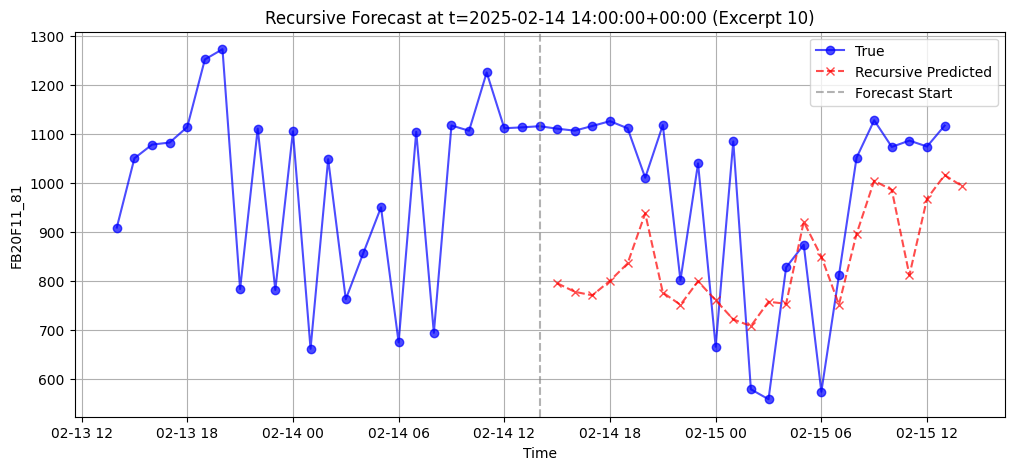

In [7]:
num_excerpts = 10
for i in range(num_excerpts):
    random_idx = np.random.randint(0, y_test.shape[0] - forecast_horizon)
    base_time = y_test.index[random_idx]
    
    plt.figure(figsize=(12, 5))
    context_range = np.arange(-forecast_horizon, forecast_horizon)
    time_steps = base_time + pd.to_timedelta(context_range, unit="h")
    
    true_values_context = np.concatenate([
        y_test.iloc[random_idx - forecast_horizon : random_idx].values.flatten(),
        y_test.iloc[random_idx : random_idx + forecast_horizon].values.flatten()
    ])
    
    plt.plot(time_steps, true_values_context, label="True", color="blue", marker="o", alpha=0.7)
    
    predicted_values = y_pred_recursive[random_idx, :forecast_horizon].flatten()
    forecast_time_steps = base_time + pd.to_timedelta(range(1, forecast_horizon + 1), unit="h")
    plt.plot(forecast_time_steps, predicted_values, label="Recursive Predicted", color="red", linestyle="dashed", marker="x", alpha=0.7)
    
    plt.title(f"Recursive Forecast at t={base_time} (Excerpt {i+1})")
    plt.xlabel("Time")
    plt.ylabel("FB20F11_81")
    plt.axvline(base_time, color="gray", linestyle="--", alpha=0.6, label="Forecast Start")
    plt.legend()
    plt.grid(True)
    
    plt.show()

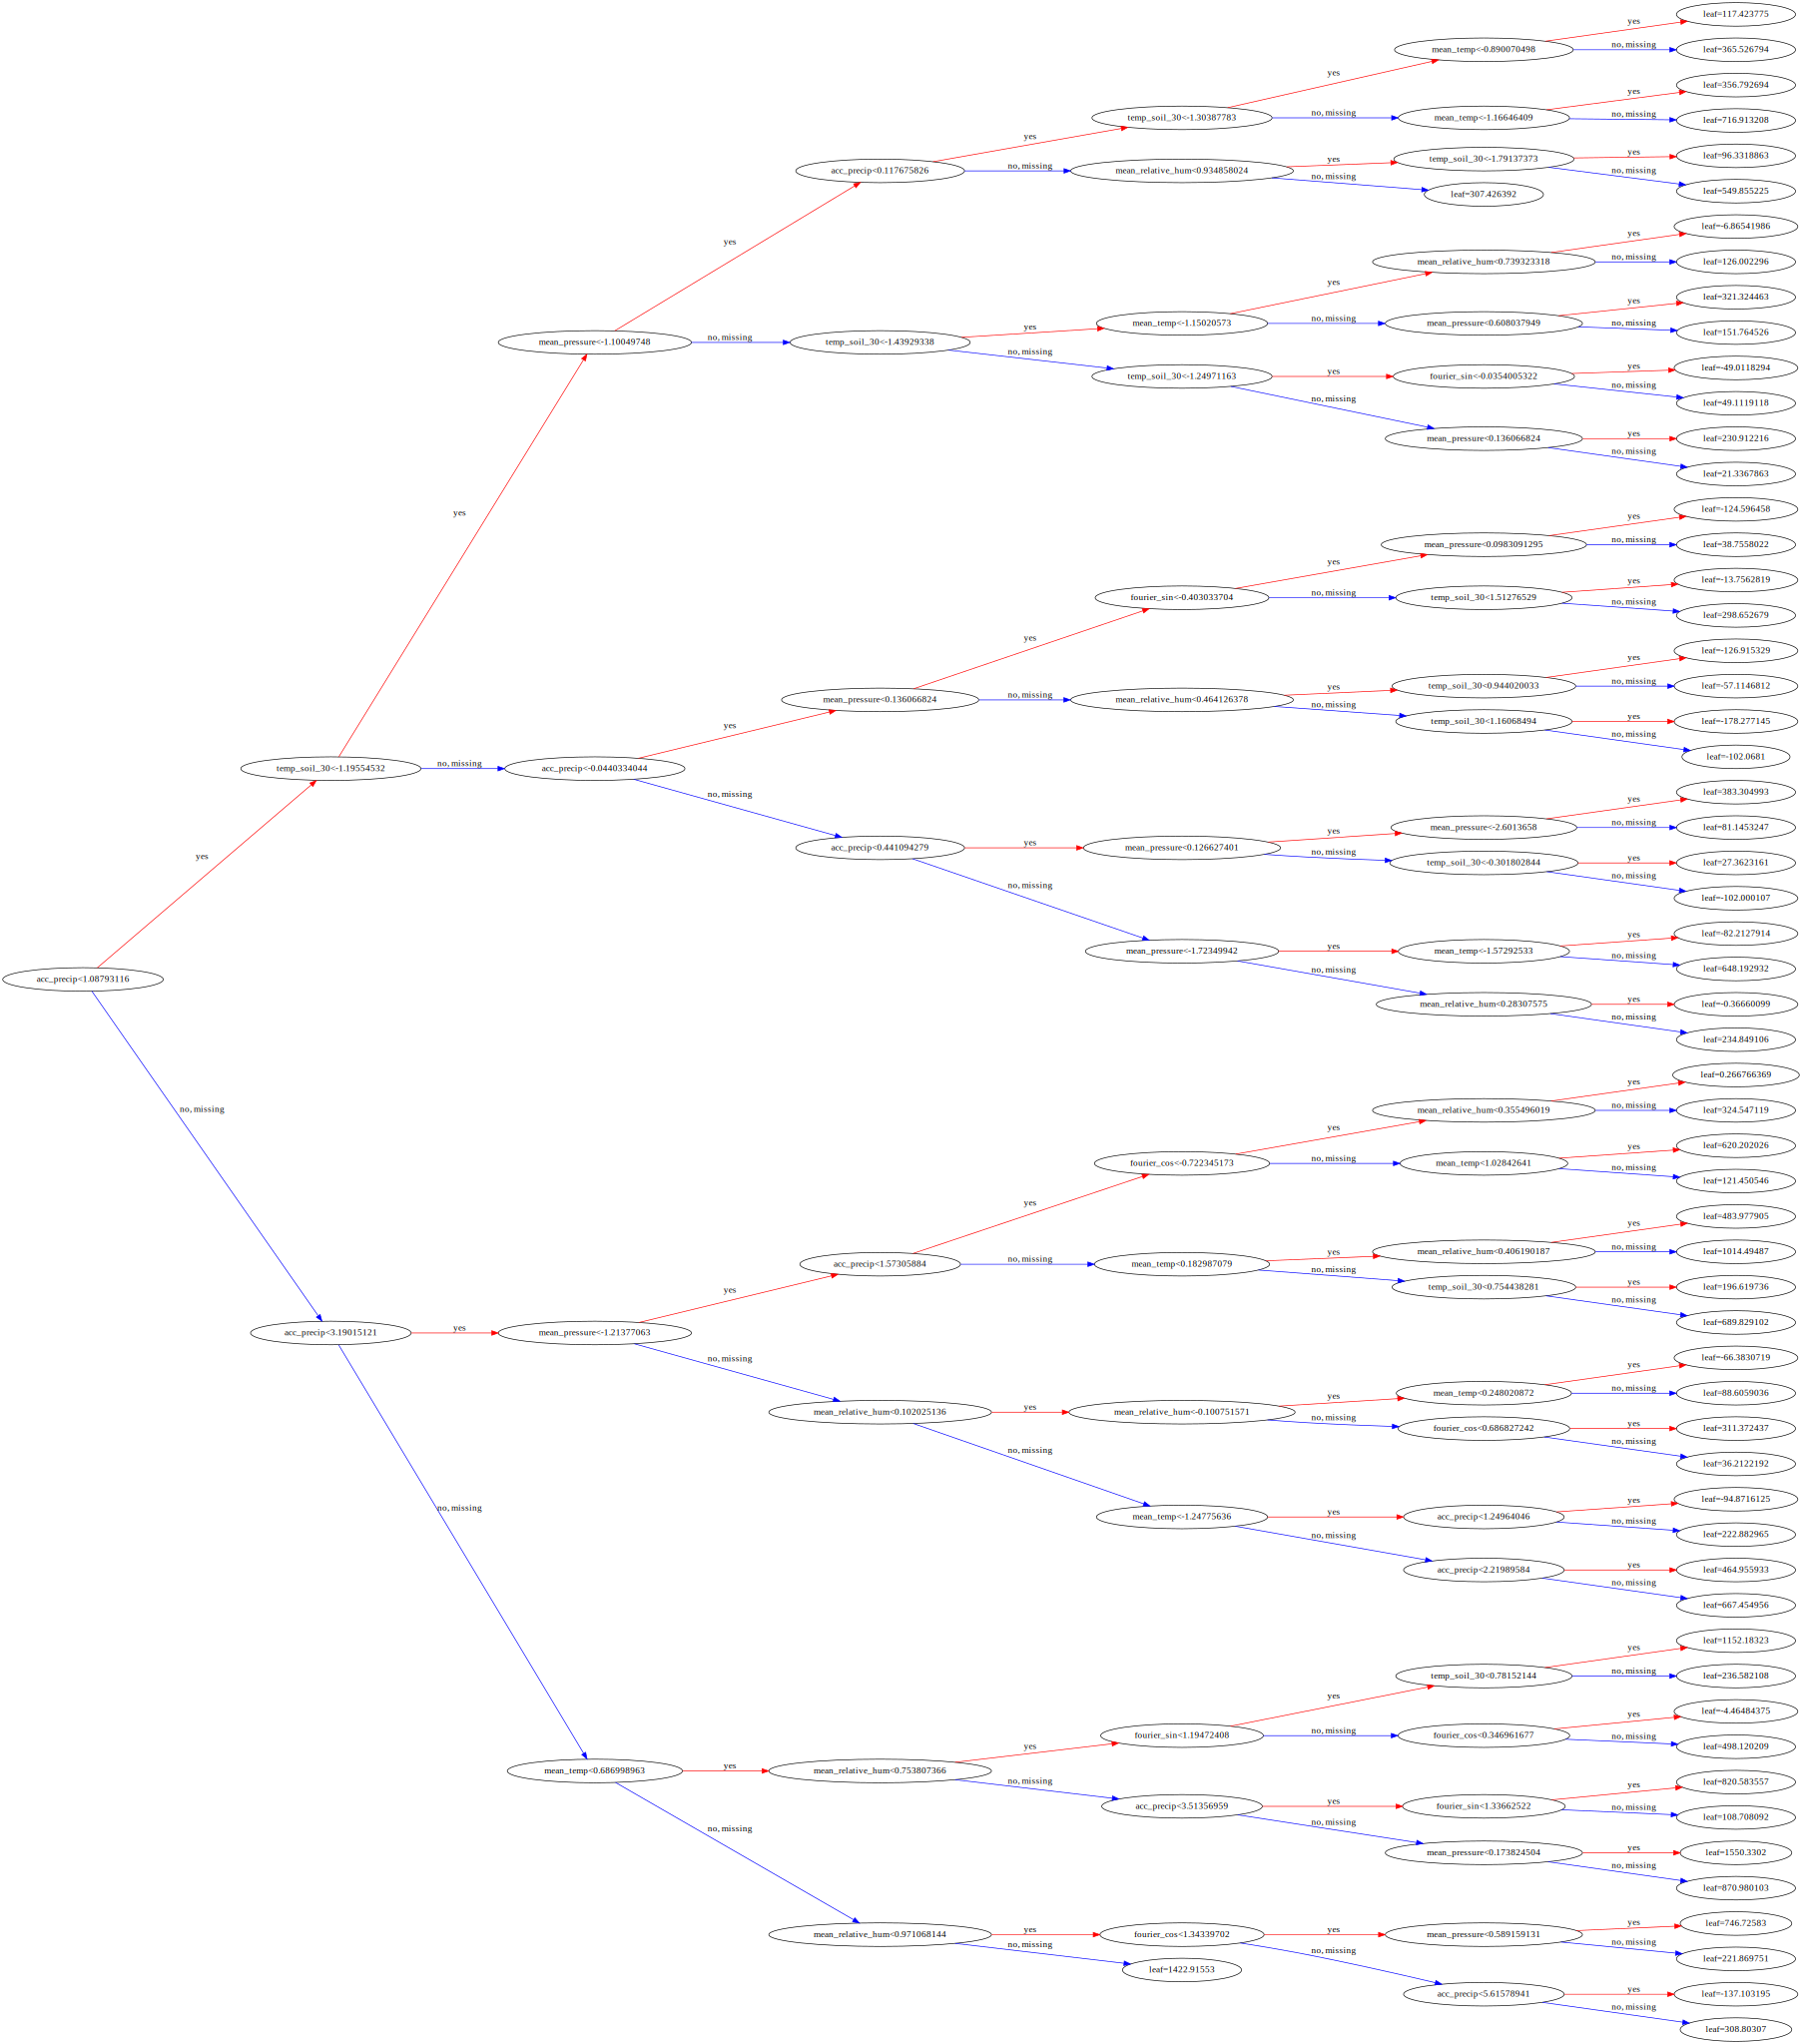

In [ ]:
import graphviz
from IPython.display import display, SVG

dot_data = xgb.to_graphviz(single_step_model, num_trees=0, rankdir='LR')
dot_data.render('xgboost_tree_recursive', format='svg')

display(SVG('xgboost_tree_recursive.svg'))

